# **Trustworthy Machine Learning**

### Winter Semester 2024-2025

### Lecturer: Seong Joon Oh

### Tutor: Lennart Bramlage

### **Exercise 3 -- Uncertainty**

---



**Group number**: >>> PLEASE FILL IN <<<



**Student names**: >>> PLEASE FILL IN <<<



**Student emails**: >>> PLEASE FILL IN <<<





---





#### **Submission deadline: 29/01/2025 at 23:59.**

This exercise is a **group exercise**. The same grade will be conferred to each member of the group based on the submission. Please report cases where any team member contributes significantly less than the other members of the same group. the The grade from this exercise will count towards the final grade.



#### **How to use GPUs**

- Verify your phone number.

- Select your preferred GPU at `Settings > Accelerator`.

- Put parameters and tensors on CUDA via `tensor.to(device)` etc.

- Double check if the parameters and tensors are on CUDA via `tensor.device` etc.



#### **Submission**

Follow the below three steps.



(1) Click on `File > Download notebook`;



(2) Send the `.ipynb` file to `stai.there@gmail.com` before the deadline.

First, let's install additional libraries we will need in this exercise.

In [3]:
%pip install -q torchmetrics datasets transformers

Note: you may need to restart the kernel to use updated packages.


In [4]:
PATH = "../input/miscellaneous"
from __future__ import annotations
import os
import random
import sys
import time
from copy import deepcopy
from typing import Callable, Optional

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lrs
import torchvision.transforms as transforms
from datasets import load_dataset
from sklearn.metrics import roc_auc_score
from torch import Tensor
from torch.distributions import Normal
from torch.nn import Module
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, Dataset, Subset
from torchmetrics import AUROC, Accuracy
from torchvision import datasets, transforms
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoModelForTokenClassification,
    AutoTokenizer,
)

sys.path.insert(0, PATH)
from unc_utils import entropy, get_cifar_loaders

def apply_random_seed(random_seed: int) -> None:
    """Sets seed to ``random_seed`` in random, numpy and torch."""
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


apply_random_seed(2025)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


# **1. Calibration and Proper Scoring (32 points)**
**Recommended start: 09.01.2025**

## 1.1 Proper scoring rules (6 points)

### 1.1.1 Proper scoring rule (3 points)
Prove that in a binary classification setup, the negative binary cross-entropy loss is a strictly proper scoring rule.

The binary cross-entropy (BCE) loss is defined as $\mathcal{L}(q, y) = - (y \log(q) + (1-y) \log(1-q))$, where $y \in \{0, 1\}$ is the binary label and $q = \hat{P}(Y=1)$ our predicted probability.

*Hint: Here, our target is predicting the correct $P(Y = 1)$. Predicting the correct $P(L = 1)$ as defined in the lecture would also be a valid target, but you do not need to do that in this exercise.*

**WRITE YOUR ANSWER HERE**

### 1.1.2 A non-proper scoring rule (3 points)

Show that, unlike BCE, the following loss function is not a strictly proper scoring rule. 
$\mathcal{L}(q,y) = - y q + (1 - y) (1 - q)$, where $y \in \{0, 1\}$ is again the binary label and $q = \hat P(Y=1)$ our predicted probability.

**WRITE YOUR ANSWER HERE**

## 1.2 Detecting uncalibrated models (26 points)

In this exercise, we will investigate the predictions of four binary classifiers,

* a calibrated and accurate model,
* a calibrated but inaccurate model,
* an uncalibrated but accurate model, and
* an uncalibrated and inaccurate model

noted `model1_outputs.csv`, `model2_outputs.csv`, `model3_outputs.csv`, and `model4_outputs.csv`. They contain model predictions $\hat{P}(Y=1)$ in the first column and the ground-truth $Y$ values in the second. Using evaluation methods of probabilistic forecasts, you will identify which is which.

In [4]:
model1 = torch.from_numpy(
    np.loadtxt(os.path.join(PATH, "model1_outputs.csv"), delimiter=",")
)
model2 = torch.from_numpy(
    np.loadtxt(os.path.join(PATH, "model2_outputs.csv"), delimiter=",")
)
model3 = torch.from_numpy(
    np.loadtxt(os.path.join(PATH, "model3_outputs.csv"), delimiter=",")
)
model4 = torch.from_numpy(
    np.loadtxt(os.path.join(PATH, "model4_outputs.csv"), delimiter=",")
)

### 1.2.1 Implement uncertainty measures (4 + 4 + 2 + 5 points)

**Implement the following evaluation methods by filling out the code below.**

* Expected calibration error (ECE)
* Reliability diagram
* Negative log-likelihood score (NLL)
* Area under the ROC curve (AUROC)

You may use `matplotlib.pyplot, torch, numpy`, but not `torch.nn` or any other libraries. Feel free to implement any other metric for investigative purposes in later tasks.

*Hint: You may want to write a helper function that you can use for both ECE and the reliability diagram.*

In [17]:
def ece_score(pred_prob: Tensor, y: Tensor, n_bins: int = 10) -> Tensor:
    """Computes the expected calibration error.

    Args:
        pred_prob: Float tensor of shape (n,) containing predicted probabilities.
        y: Float tensor of shape (n,) containing the ground-truth 0 and 1 labels.
        n_bins: Number of (equally sized) bins.

    Returns:
        The ECE in a float tensor of shape (1,).

    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    ece_score = 0
    y_preds = (pred_prob > 0.5)
    for m in range (1,n_bins+1):
        lower = (m-1)/n_bins
        upper = m/n_bins
        binm = torch.nonzero((pred_prob > lower) & (pred_prob <= upper), as_tuple=False).squeeze()
        if len(binm) < 1:
            ece_score += 0
        else:
            #print ("Probability :\n",pred_prob[binm])
            #print ("Predictions :\n",y_preds[binm])
            #print ("True values :\n",y[binm].unique(return_counts = True))
            binm_acc = (1.0/abs(len(binm))) * torch.sum (y_preds[binm] == y[binm])
            binm_conf = (1.0/abs(len(binm))) * torch.sum (pred_prob[binm])
            ece_score += (len(binm)/len(pred_prob)) * torch.abs (binm_acc - binm_conf)
    #### >>>> END OF YOUR SOLUTION <<<<
    return ece_score

In [6]:
def reliability_diagram(pred_prob: torch.Tensor, y: torch.Tensor, n_bins: int = 10) -> None:
    """Visualizes a reliability diagram.

    Args:
        pred_prob: Float tensor of shape (n,) containing predicted probabilities.
        y: Float tensor of shape (n,) containing the ground-truth 0 and 1 labels.
        n_bins: Number of (equally sized) bins.
    """
    from sklearn.calibration import calibration_curve, CalibrationDisplay
    accs = []
    confs = []
    bin_counts = []

    # Calculate accuracy and confidence for each bin
    for m in range(1, n_bins + 1):
        lower = (m - 1) / n_bins
        upper = m / n_bins
        binm = torch.nonzero((pred_prob > lower) & (pred_prob <= upper), as_tuple=False).squeeze()

        if len(binm) > 0:
            bin_acc = (y[binm] == 1).float().mean().item()
            bin_conf = pred_prob[binm].mean().item()
        else:
            bin_acc = 0.0
            bin_conf = 0.0

        accs.append(bin_acc)
        confs.append(bin_conf)
        bin_counts.append(len(binm))

    #print (accs)
    #print (confs)
    #prob_true, prob_pred = calibration_curve (y, pred_prob, pos_label=None, n_bins=10, strategy='uniform')
    #disp = CalibrationDisplay(prob_true, prob_pred, pred_prob)
    #print ("Prob True : ",prob_true)
    #print ("Prob Pred : ",prob_pred)
    #disp.plot()
    
    # Plot reliability diagram
    plt.figure(figsize=(8, 6))
    bin_edges = np.linspace(0, 1, n_bins + 1)  # Bin edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints of the bins
    plt.bar(bin_centers, accs, width=1 / n_bins, edgecolor="black", alpha=0.7, label="Accuracy")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
    
    # Labels and Legend
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Reliability Diagram")
    plt.legend(loc="upper left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [7]:
def nll_score(pred_prob, y):
    """Computes the negative log-likelihood score.

    Args:
        pred_prob: Float tensor of shape (n,) containing predicted probabilities.
        y: Float tensor of shape (n,) containing the ground-truth 0 and 1 labels.
        n_bins: Number of (equally sized) bins.

    Returns:
        The NLL in a float tensor of shape (1,).

    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    nll_score = 0
    for i in range (len(y)):
        nll_score -= (y[i] * torch.log(pred_prob[i]) + (1 - y[i]) * torch.log(1 - pred_prob[i]))
    #### >>>> END OF YOUR SOLUTION <<<<

    return nll_score

There are several ways to calculate the AUROC. We'll use a simplified one for the sake of this exercise. First, calculate false-positive and true-positive rates for all possible thresholds (Which are these?). The AUROC is an integral over this curve. You don't need to implement fancy trapezoidal rules nor triangles to approximate this integral, but may simply use rectangles below the curve.

In [8]:
def auroc_score(pred_prob: Tensor, y: Tensor) -> Tensor:
    """Computes the area under the ROC curve score.

    Args:
        pred_prob: Float tensor of shape (n,) containing predicted probabilities.
        y: Float tensor of shape (n,) containing the ground-truth 0 and 1 labels.

    Returns:
        The AUROC in a float tensor of shape (1,).

    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    from sklearn.metrics import roc_auc_score
    t = torch.sort(torch.unique(pred_prob)).values
    tpr = []
    fpr = []
    auroc_score = 1

    #print (t)
    
    for i in range (len (t)):
        tp = [a for a in range(len(y)) if y[a] == 1 and pred_prob[a]>=t[i]]
        fp = [a for a in range(len(y)) if y[a] == 0 and pred_prob[a]>=t[i]]
        tn = [a for a in range(len(y)) if y[a] == 0 and pred_prob[a]<t[i]]
        fn = [a for a in range(len(y)) if y[a] == 1 and pred_prob[a]<t[i]]
 
        #print (len(tp), len(fp), len(tn), len(fn))

        tpr.append(len(tp)/(len(tp) + len(fn) + 0.0001))
        fpr.append(len(fp)/(len(tn) + len(fp) + 0.0001))

        if i == 0:
            auroc_score -= (tpr[i])*(fpr[i])
        else :
            auroc_score -= (tpr[i])*(fpr[i] - fpr[i-1])

    #print ("correct auroc", roc_auc_score(y,pred_prob))

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUROC = {auroc_score:.4f})", marker='o', linestyle='-', color='blue')
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")  # Diagonal line
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
    
    #### >>>> END OF YOUR SOLUTION <<<<

    return torch.tensor (auroc_score)

### 1.2.2 Interpret the results (4 points)
Apply your scores implemented above to the model results and **argue which model is which and why.**
For uncalibrated models, also answer **whether they are overconfident, underconfident, or a mixture**.

If you could not implement the models in 1.2.1, you may use existing libraries to gain points here. Feel free to add additional metrics of existing libraries if you find them useful for finding out which model is which (or implement them yourself if you feel adventurous).

*Hint: Be critical of your metrics! Each metric only evaluates a certain property of the model. Some metrics might even be misleading due to other properties of the model that are not easily visible.*

Model1 ECE: 0.3173345053906378
Model1 NLL: 721.5890474531179


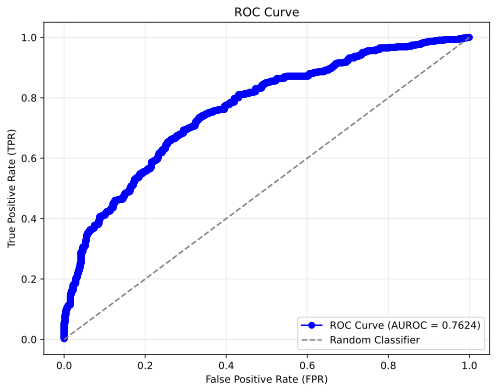

Model1 AUROC: 0.7623592019081116


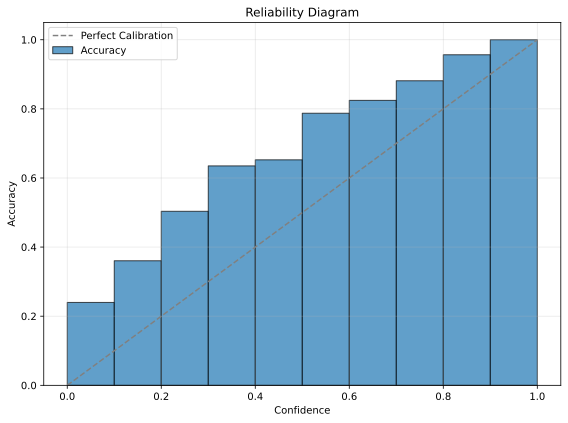

In [18]:
print(f"Model1 ECE: {ece_score(model1[:,0], model1[:,1]).item()}")
print(f"Model1 NLL: {nll_score(model1[:,0], model1[:,1]).item()}")
print(f"Model1 AUROC: {auroc_score(model1[:,0], model1[:,1]).item()}")
reliability_diagram(model1[:, 0], model1[:, 1])
plt.show()

Model2 ECE: 0.2014286620542407
Model2 NLL: 588.1873570559447


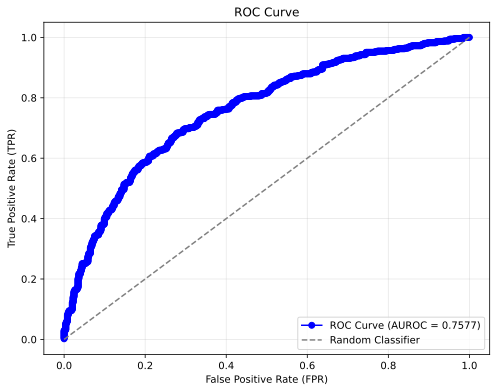

Model2 AUROC: 0.7577131986618042


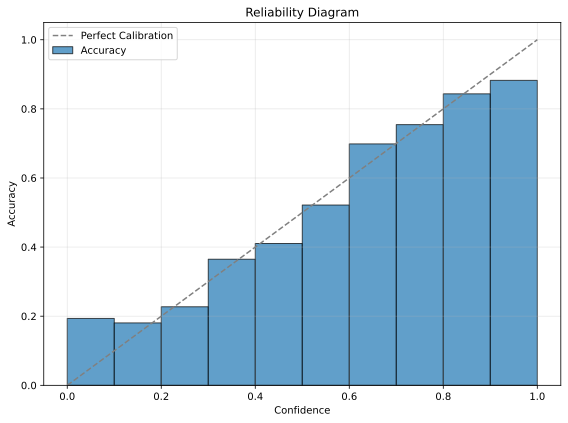

In [86]:
print(f"Model2 ECE: {ece_score(model2[:,0], model2[:,1]).item()}")
print(f"Model2 NLL: {nll_score(model2[:,0], model2[:,1]).item()}")
print(f"Model2 AUROC: {auroc_score(model2[:,0], model2[:,1]).item()}")
reliability_diagram(model2[:, 0], model2[:, 1])
plt.show()

Model3 ECE: 0.45500761782786453
Model3 NLL: 66.86655541334747


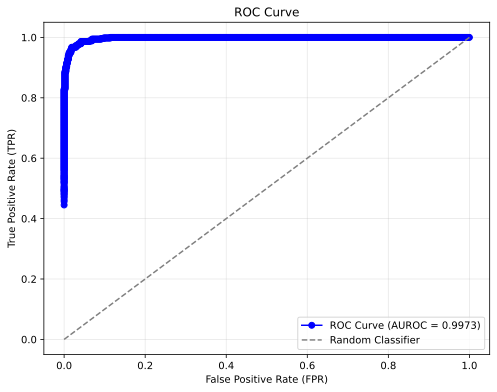

Model3 AUROC: 0.9972800612449646


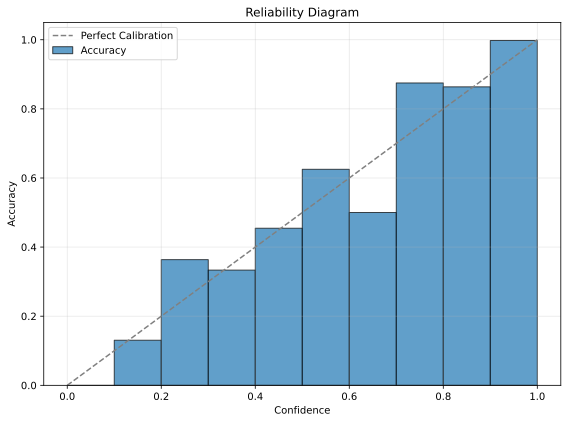

In [87]:
print(f"Model3 ECE: {ece_score(model3[:,0], model3[:,1]).item()}")
print(f"Model3 NLL: {nll_score(model3[:,0], model3[:,1]).item()}")
print(f"Model3 AUROC: {auroc_score(model3[:,0], model3[:,1]).item()}")
reliability_diagram(model3[:, 0], model3[:, 1])
plt.show()

Model4 ECE: 0.2626516219891498
Model4 NLL: nan


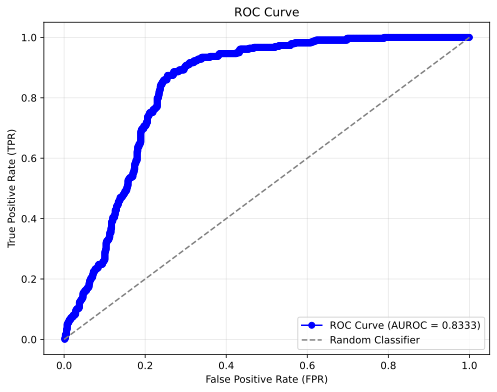

Model4 AUROC: 0.8332614898681641


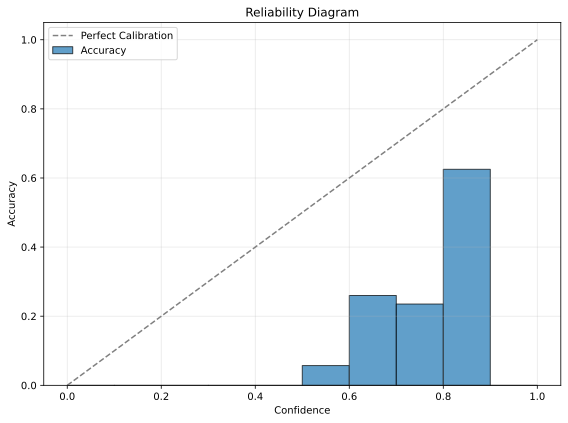

In [88]:
print(f"Model4 ECE: {ece_score(model4[:,0], model4[:,1]).item()}")
print(f"Model4 NLL: {nll_score(model4[:,0], model4[:,1]).item()}")
print(f"Model4 AUROC: {auroc_score(model4[:,0], model4[:,1]).item()}")
reliability_diagram(model4[:, 0], model4[:, 1])
plt.show()

**Model XY is calibrated and accurate** because **WRITE YOUR ANSWER HERE**.

**Model XY is uncalibrated but accurate** because **WRITE YOUR ANSWER HERE**. **It is overconfident/underconfident/mixture of both** because **WRITE YOUR ANSWER HERE**.

**Model XY is calibrated but inaccurate** because **WRITE YOUR ANSWER HERE**.

**Model XY is uncalibrated and inaccurate** because **WRITE YOUR ANSWER HERE**. **It is overconfident/underconfident/mixture of both** because **WRITE YOUR ANSWER HERE**.

**Bonus question (2 points)**: Why does the reliability diagram of model 3 look so weird?

**WRITE YOUR ANSWER HERE**

### 1.2.3 Cheating the ECE (4 points)

The final model, `model5_outputs.csv`, has a very bad looking ECE. The ground-truth $y$ values were unfortunately randomly shuffled (`model5_truths_shuffled.csv`) so there is no option to improve performance in a scientifically rigorous way. Let's cheat (Yikes!) to make the score look better on paper than the model is.

**Write a function that adapts the predicted probabilities to increase the ECE score of the model** (with `n_bins = 10`). To make sure that you don't cheat while cheating, `model5_truths_shuffled.csv` only contains a randomly permuted variant of the ground-truth values. The current ECE of model5 on the real ground-truth values is 0.25. You get full points if you manage to decrease it below 0.2 by any means.

*Hint: Test your function by applying it to models 1-4 and calculating their ECE.*

In [27]:
model5 = torch.from_numpy(
    np.loadtxt(os.path.join(PATH, "model5_outputs.csv"), delimiter=",")
)
model5_shuffled_y = torch.from_numpy(
    np.loadtxt(os.path.join(PATH, "model5_truths_shuffled.csv"), delimiter=",")
)

In [20]:
model5

tensor([3.3152e-01, 4.9410e-01, 2.6087e-01, 2.5020e-01, 1.0862e-01, 4.7263e-01,
        3.7217e-03, 4.6391e-01, 3.4134e-03, 8.1085e-02, 2.3725e-01, 1.5627e-01,
        5.1690e-01, 2.5487e-02, 2.0376e-03, 6.4393e-03, 2.4275e-01, 2.8624e-01,
        2.2126e-01, 7.9861e-01, 2.3649e-01, 1.9698e-02, 4.2902e-01, 3.7933e-02,
        2.0281e-02, 1.1905e-01, 3.2650e-02, 7.6727e-03, 2.8210e-06, 1.0293e-03,
        8.7269e-01, 1.3326e-01, 6.6847e-01, 9.6626e-07, 4.8571e-04, 9.8120e-02,
        1.8985e-01, 9.4569e-01, 5.5186e-05, 6.1990e-02, 5.4660e-01, 8.6297e-01,
        2.6937e-02, 5.1627e-01, 5.9090e-01, 1.6036e-02, 3.1665e-03, 3.4658e-01,
        3.2345e-02, 6.6917e-01, 5.5920e-02, 4.5998e-04, 1.7083e-01, 4.0081e-03,
        1.4518e-01, 1.0051e-01, 4.3737e-01, 8.4869e-02, 5.3579e-01, 1.1096e-02,
        5.6063e-02, 7.4973e-01, 1.0356e-01, 3.7205e-01, 3.8722e-01, 3.9458e-01,
        8.4764e-02, 1.3642e-01, 5.6056e-01, 3.0371e-05, 1.8322e-01, 4.1752e-01,
        8.7845e-01, 3.6008e-01, 4.7866e-

In [28]:
print(f"Model5 ECE: {ece_score(model5, model5_shuffled_y).item()}")

Model5 ECE: 0.32968960677440184


In [42]:
def increase_ece(pred_prob: Tensor, shuffled_y: Tensor):
    """Adapts the predicted probabilities to make them look better under the ECE measure.

    Args:
        pred_prob: Float tensor of shape (n,) containing predicted probabilities.
        y: Float tensor of shape (n,) containing randomly permuted 0 and 1 labels.

    Returns:
        A float tensor of the same shape as pred_prob with adapted probabilities.

    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    ece_score = 0
    n_bins = 10
    y_preds = (pred_prob > 0.5)
    new_pred_prob = pred_prob.clone().detach()
    for m in range (1,n_bins+1):
        lower = (m-1)/n_bins
        upper = m/n_bins
        binm = torch.nonzero((pred_prob > lower) & (pred_prob <= upper), as_tuple=False).squeeze()
        if len(binm) == 0:
            continue
        else:
            binm_acc = (1.0/abs(len(binm))) * torch.sum (y_preds[binm] == shuffled_y[binm])
            binm_conf = (1.0/abs(len(binm))) * torch.sum (pred_prob[binm])
            gap = binm_acc - binm_conf
            alpha = 0.5
            if gap > 0:
                new_pred_prob[binm] = new_pred_prob[binm] + alpha * gap
            else :
                new_pred_prob[binm] = new_pred_prob[binm] - alpha * gap

    #### >>>> END OF YOUR SOLUTION <<<<
    return new_pred_prob


# A small verification for yourselves on data where you know the GT y:
old_ece = ece_score(model4[:, 0], model4[:, 1]).item()
new_ece = ece_score(
    increase_ece(model4[:, 0], model4[torch.randperm(model4.shape[0]), 1]), model4[:, 1]
).item()
print(f"Model 4: Old ECE was {old_ece} and new ECE is {new_ece}")

Model 4: Old ECE was 0.36212123645076155 and new ECE is 0.30762619256277934


In [43]:
old_ece = ece_score(model5, model5_shuffled_y,n_bins = 10).item()
new_ece = ece_score(
    increase_ece(model5, model5_shuffled_y), model5_shuffled_y)
print(f"Model 5: Old ECE was {old_ece} and new ECE is {new_ece}")

Model 5: Old ECE was 0.32968960677440184 and new ECE is 0.1864447546616036


### 1.2.4 Cheat prevention (3 points)
A model can abuse the above adversarial techniques to decrease the ECE by returning probabilities that aren't its true beliefs. **Argue why any cheat like this is impossible for NLL (unless the model truly becomes better).**

**WRITE YOUR ANSWER HERE** (no proof required)

**Bonus question (4 points)**: Comparing scoring rules. In the lecture, we have seen a few strictly proper scoring rules for predictive uncertainty, and also some lower bounds thereof. Below, we provide some boilerplate for downloading the CIFAR-10 dataset.

Try out any two proper scoring rules from the lecture as training objectives. Make sure you provide a fair comparison: some scoring rules might require different hyperparameters than others. Do you get different accuracies and calibration? Use the evaluation methods you have implemented above to support your findings.

In [ ]:
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 10

In [ ]:
train_loader, val_loader, test_loader = get_cifar_loaders()

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=30, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=30, out_channels=50, kernel_size=3)
        self.fc = nn.Linear(in_features=50 * 4 * 4, out_features=10)

    def forward(self, x: Tensor) -> Tensor:
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)

        return x

In [ ]:
def train_single_loop(
    model: SimpleNet,
    device: str,
    train_loader: DataLoader,
    optimizer: Adam,
    loss_fn: Callable,
) -> None:
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()


def val(
    model: SimpleNet,
    device: str,
    val_loader: DataLoader,
    epoch: int,
    loss_fn: Callable,
) -> None:
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            pred = output.argmax(dim=-1)

            val_loss += loss_fn(output, target).item()
            correct += (pred == target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / len(val_loader.dataset)

    print(
        f"[Epoch {epoch:2d}]: Average loss: {val_loss:.4f}, "
        f"Accuracy: {correct}/{len(val_loader.dataset)} ({val_accuracy:.0f}%)"
    )


def train(
    model: SimpleNet,
    device: str,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: Adam,
    loss_fn: Callable,
    scheduler: Optional[MultiStepLR] = None,
    num_epochs: int = 10,
) -> None:
    model = model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_single_loop(model, device, train_loader, optimizer, loss_fn)

        model.eval()
        val(model, device, val_loader, epoch, loss_fn)

        if scheduler is not None:
            scheduler.step()

    print("Done!")

In [ ]:
#### >>>> PUT YOUR SOLUTION HERE <<<<
# Implement your losses/scores of choice from the lecture.
# Train the models, tune the hyperparameters.
# Evaluate the models using the metrics you implemented above (on the test dataloader).
#### >>>> END OF YOUR SOLUTION <<<<

# **2. Epistemic Uncertainty and Ensembles (25 points)**
**Recommended start: 16.01.2025**

## 2.1 Epistemic Uncertainty Applications (6 points)

Find two papers that are concerned with two different applications of epistemic uncertainty. You're allowed to cite any paper except those mentioned in the lecture. You don't need to read the whole paper, but can instead practice quick [paper skimming](https://web.stanford.edu/class/ee384m/Handouts/HowtoReadPaper.pdf): Read only the title, abstract, introduction, section titles, figures, and the conclusion. Once you found compelling papers, **shortly address the following tasks for each of your two chosen papers:**

0. Provide a link to the paper.
1. Summarize the motivating problem of the paper.
2. How is this problem related to epistemic uncertainty?
3. How relevant do you find this problem in practice?

**WRITE YOUR ANSWER HERE**

## 2.2 Setup for Experiments (0 points)

In this exercise, we want to train ensemble methods to output epistemic uncertainties in an OOD task. In particular, we want to train on CIFAR-10 as in-distribution and test on CIFAR-100 as out-of-distribution dataset, so let's first load these two datasets:

In [ ]:
BATCH_SIZE = 64

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

traindata_10 = datasets.CIFAR10(
    root="./data_CIFAR10_train", train=True, download=True, transform=transform
)
trainloader_10 = DataLoader(
    traindata_10, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

testdata_10 = datasets.CIFAR10(
    root="./data_CIFAR10_test", train=False, download=True, transform=transform
)
testloader_10 = DataLoader(
    testdata_10, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

# We will not need the CIFAR100 train dataset

testdata_100 = datasets.CIFAR100(
    root="./data_CIFAR100_test", train=False, download=True, transform=transform
)
testloader_100 = DataLoader(
    testdata_100, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

We will use a simple CNN as architecture.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # x: (b, 3, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))
        # x: (b, 6, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))
        # x: (b, 16, 5, 5)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch.
        # x: (b, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        # x: (b, 120)
        x = F.relu(self.fc2(x))
        # x: (b, 84)
        x = self.fc3(x)
        # x: (b, 10)
        return x

As a baseline, we train the above `Net`. Let's train for 5 epochs. This might lead to imperfect performance, but we also have to take the fairness of comparison into account. We also train one for 25 epochs.

In [ ]:
def train_loop(
    net: nn.Module,
    dataloader: DataLoader,
    criterion: Callable[[Tensor, Tensor], Tensor] = nn.CrossEntropyLoss(),
    n_epochs: int = 5,
    lr: float = 1e-3,
) -> nn.Module:
    """Implements a basic, general training loop for supervised learning.

    Args:
        net: Neural network to train.
        dataloader: DataLoader object used for training.
        criterion: Criterion (loss function) used for training.
        n_epochs: Number of epochs to train the model.
        lr: Learning rate used for Adam gradient updates.

    Returns:
        The trained neural network.

    """
    optimizer = optim.Adam(net.parameters(), lr=lr)

    net = net.to(device)
    net.train()
    for epoch in range(n_epochs):  # Loop over the dataset multiple times.
        running_loss = 0.0
        for batch in tqdm(dataloader):
            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward + backward + optimize.
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Finished epoch {epoch}. Loss: {running_loss / len(dataloader):.3f}")

    net.eval()
    print("Finished Training")
    return net


net_baseline_5 = train_loop(Net(), trainloader_10, n_epochs=5)
net_baseline_25 = train_loop(Net(), trainloader_10, n_epochs=25)

Let's see how good it performs on OOD data:

In [ ]:
def evaluate(
    net: nn.Module, in_distr_dataloader: DataLoader, out_distr_dataloader: DataLoader
) -> tuple[Tensor, Tensor, Tensor]:
    """Evaluates ``net``'s accuracy and AUROC scores wrt. both maximum probability
    and entropy based on how well the OOD-ness of the data can be determined from
    these scores.

    Args:
        net: Neural network to evaluate.
        in_distr_dataloader: DataLoader object containing the in-distribution test dataset.
        out_distr_dataloader: DataLoader object containing the out-of-distribution
            test dataset.

    Returns:
        The accuracy of ``net`` on the in-distribution test dataset, and the AUROC scores
        wrt. both maximum probability and entropy.

    """

    def pred_dataset(net, dataloader):
        # Iterates over a dataloader and delivers predictions of net and the GT labels.
        preds = []
        gts = []

        with torch.no_grad():
            for batch in tqdm(dataloader):
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                pred = net(images)
                preds.append(pred)
                gts.append(labels)

        preds = torch.cat(preds, dim=0)
        # Transform logits to probabilities.
        preds = F.softmax(preds, dim=1)
        gts = torch.cat(gts, dim=0)

        return preds, gts

    def calc_entropy(x, dim=1):
        return -torch.sum(x * torch.log(x), dim=dim)

    # Predict the datasets.
    pred_in, gt_in = pred_dataset(net, in_distr_dataloader)
    pred_out, gt_out = pred_dataset(net, out_distr_dataloader)

    # Calculate the accuracy.
    accuracy = Accuracy(task="multiclass", num_classes=10, top_k=1).to(device)
    acc = accuracy(pred_in, gt_in)

    # Calculate AUROC for distinguishing ID from OOD data
    # ... based on the maximum probability.
    max_prob = torch.cat(
        [torch.max(pred_in, dim=1)[0], torch.max(pred_out, dim=1)[0]], dim=0
    )
    id_or_ood = torch.cat(
        [
            torch.ones(pred_in.shape[0], device=pred_in.device),
            torch.zeros(pred_out.shape[0], device=pred_out.device),
        ],
        dim=0,
    )
    id_or_ood = id_or_ood.int()
    auroc = AUROC(task="binary")
    auroc_max_prob = auroc(max_prob, id_or_ood)

    # ... based on prediction entropy.
    entropy = -torch.cat((calc_entropy(pred_in), calc_entropy(pred_out)), dim=0)
    auroc_entropy = auroc(entropy, id_or_ood)

    print(
        f"\nAccuracy: {acc:.3f}, AUROC max_prob: {auroc_max_prob:.3f}, "
        f"AUROC entropy: {auroc_entropy:.3f}"
    )

    return acc, auroc_max_prob, auroc_entropy


acc_baseline, auroc_max_prob_baseline, auroc_entropy_baseline = evaluate(
    net_baseline_5, testloader_10, testloader_100
)
acc_baseline, auroc_max_prob_baseline, auroc_entropy_baseline = evaluate(
    net_baseline_25, testloader_10, testloader_100
)

Now we have some baseline results. Please copy/paste them down into the results section below, in case your notebook crashes. Let's implement and train some ensembles that hopefully do better!

## 2.3 Bagging Ensemble (4 points)

First, **implement a simple bagging ensemble** comprising 5 ensemble members. For this, you need bootstrapped dataloaders. Train your ensemble members on them. Finally, wrap them into an ensemble module that calculates the average of their predicted probability distributions and then, for compatibility with the above code, return logits of these. **(Make sure you follow this instruction correctly!)**

Feel free to use the above code to your own needs. As always, you're not allowed to import any libraries other than for basic arithmetics. You're allowed to use `torch.utils.data.Subset`.

*I suggest not copy-pasting code. If you need the exact same code twice, you should make it a function that you can call multiple times. If you need a modified version of the code, first think whether making it a function with different options would make it too complicated. If so, make a separate function while consulting the original code snippet.*

In [ ]:
N_ENSEMBLE_MEMBERS = 5


def prepare_dataloaders(
    dataset: Dataset, n_subsets: int, batch_size: int = 64
) -> list[DataLoader]:
    """Creates a list of ``DataLoader``s by bootstrapping ``dataset``.

    Args:
        dataset: The entire training dataset that is bootstrapped.
        n_subsets: The number of bootstrapped subsets of ``dataset`` that are prepared.
        batch_size: The size of minibatches the ``DataLoader``s return.

    Returns:
        A list of bootstrapped ``DataLoader``s of length ``n_subsets``.

    """
    dataloaders = []  # This list should contain 5 dataloaders eventually.
    #### >>>> PUT YOUR SOLUTION HERE <<<<

    #### >>>> END OF YOUR SOLUTION <<<<
    return dataloaders


dataloaders = prepare_dataloaders(traindata_10, N_ENSEMBLE_MEMBERS)
members = [Net() for i in range(N_ENSEMBLE_MEMBERS)]

In [ ]:
# Train the ensemble.
start = time.time()
for member, dataloader in zip(members, dataloaders):
    train_loop(member, dataloader)
end = time.time()
print(f"Total training time (s): {end - start}")

Let's write a wrapper so that we can use the ensemble like any other network. Make sure to read the instructions in the ``forward()`` method carefully.

In [ ]:
class AverageEnsemble(nn.Module):
    def __init__(self, members: list[nn.Module]) -> None:
        super().__init__()
        #### >>>> PUT YOUR SOLUTION HERE <<<<
        # A list of nn.Modules that have a .forward() function.
        #### >>>> END OF YOUR SOLUTION <<<<

    def forward(self, x: Tensor) -> Tensor:
        """Calculates logits for each member and each image, transforms them into
        probabilities, averages those probabilities across members, then transforms them
        back into logits for each image.

        Args:
            x: Float tensor of shape (batch_size, *input_dims) containing the input batch
                of data for which each member of the ensemble predicts logits that are
                further processed as described above.

        Returns:
            A float tensor of shape (batch_size, n_classes) containing the logits
            corresponding to the average predicted probabilities by each member of the
            ensemble.

        """
        #### >>>> PUT YOUR SOLUTION HERE <<<<
        
        #### >>>> END OF YOUR SOLUTION <<<<
        return avg_logit

In [ ]:
# Evaluate the ensemble. We'll do the comparison further down below.
# Copy-paste your results to the results section below.
acc_bagging, auroc_max_prob_bagging, auroc_entropy_bagging = evaluate(
    AverageEnsemble(members), testloader_10, testloader_100
)

**Bonus question (2 points):** A [Balaji ensemble](https://arxiv.org/abs/1612.01474) is very similar to this. Which line(s) of the code would you need to change in order to get a Balaji ensemble instead (apart from the adversarial training proposed by Balaji et al.)?

**WRITE YOUR ANSWER HERE**

## 2.4 Dropout (5 points)

Next, **add a variation of our `Net()` that uses Monte Carlo Dropout (p=0.25)** after both convolution and linear layers. Make sure the dropout is used both at train and test time to ensure we actually test on an ensemble.

You are allowed to copy-paste code from above and use the Dropout Modules of `torch.nn`.

In [ ]:
class DropoutNet(nn.Module):
    def __init__(self, p=0.25):
        super().__init__()
        # Hint: start from the code of the baseline model, then add the dropout layers
        #### >>>> PUT YOUR SOLUTION HERE <<<<

        #### >>>> END OF YOUR SOLUTION <<<<

    def forward(self, x: Tensor) -> Tensor:
        """Implements the forward propagation in a DropoutNet.

        Args:
            x: Tensor of shape (batch_size, *input_dims) containing the image batch.

        Returns:
            A tensor of shape (batch_size, n_classes) containing the logits corresponding
            to the predicted probability of the randomly masked network for each input
            image.

        """
        # Hint: start from the code of the baseline model, then add the dropout layers
        #### >>>> PUT YOUR SOLUTION HERE <<<<
        # Luckily, we can re-use code from above
        #### >>>> END OF YOUR SOLUTION <<<<

        return x

For fairness and to counteract the stochasticity, we'll give this network 5*5=25 epochs.

In [ ]:
net_dropout = train_loop(DropoutNet(), trainloader_10, n_epochs=25)

Now, **set your model to eval mode but keep the Dropout activated**. Then, build a wrapper that predicts 5 times per input, thus simulating five "ensemble members". The wrapper should return the logits of the averaged predicted probabilities of your 5 "ensemble members", just as in the `AverageEnsemble`.

*If you're feeling fancy,* you can try to find a trick to re-use the whole `AverageEnsemble` class from above.

In [ ]:
def enable_dropout(model: nn.Module) -> None:
    """Enables the dropout layers of ``model`` during test time.

    Args:
        model: Module for which the dropout layer should be activated.

    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<

    #### >>>> END OF YOUR SOLUTION <<<<


net_dropout.eval()
enable_dropout(net_dropout)
#### >>>> PUT YOUR SOLUTION HERE <<<<
dropout_ensemble = ...
#### >>>> END OF YOUR SOLUTION <<<<

Last, evaluate and copy-paste your results to the results section below.

In [ ]:
acc_dropout, auroc_max_prob_dropout, auroc_entropy_dropout = evaluate(
    dropout_ensemble, testloader_10, testloader_100
)

## 2.5 Fast Geometric Ensembling (6 points)

Last, we want to implement [fast geometric ensembling](https://papers.nips.cc/paper/2018/file/be3087e74e9100d4bc4c6268cdbe8456-Paper.pdf). For this, start with the already trained `net_baseline` and save it as a snapshot. Then, train it with a learning rate increasing from `1e-4` to `1e-2` for two epochs, and then with a decreasing learning rate from `1e-2` to `1e-4` for two epochs. Save the new model as another snapshot. Repeat this process until you have the baseline model and four additional models.

The code below implements this training procedure. **Fill it out.** You may use `copy.deepcopy()` and any function in `torch.optim.lr_scheduler`.

**Bonus question (2 points)**: Why do we use SGD here instead of Adam?

*Hint: Think about what the learning rate means in Adam.*

**WRITE YOUR ANSWER HERE**

In [ ]:
def fast_geometric_ensembling(
    net: nn.Module,
    dataloader: DataLoader,
    criterion: Callable[[Tensor, Tensor], Tensor] = nn.CrossEntropyLoss(),
    n_cycles: int = 4,
) -> list[nn.Module]:
    """Implements fast geometric ensembling of an already trained model.

    Args:
        net: Network that is already trained.
        dataloader: Dataloader of the dataset we wish to further train ``net``.
        criterion: Criterion (loss function) used for training.
        n_cycles: Number of times we repeated the learning rate increase and
            decrease procedure (where each repeat gives an additional model).

    Returns:
        A list of models of length ``n_cycles + 1`` obtained by repeating the learning rate
        increase and decrease procedure.

    """

    def train_loop_one_epoch(
        net: nn.Module,
        dataloader: DataLoader,
        criterion: Callable[[Tensor, Tensor], Tensor],
        optimizer: optim.SGD,
        scheduler: lrs.ChainedScheduler,
    ) -> None:
        """Performs training of ``net`` for one epoch over ``dataloader``, using
        ``scheduler`` to update the learning rate throughout.

        Args:
            net: Network to be trained further.
            dataloader: Dataloader of the dataset we wish to further train ``net``.
            criterion: Criterion (loss function) used for training.
            optimizer: Optimizer object for SGD.
            scheduler: Scheduler object that linearly increases learning rate from 1e-4
                to 1e-2 and decreases it from 1e-2 back to 1e-4 over 2+2 epochs.

        """
        net = net.to(device)

        for batch in tqdm(dataloader):
            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward + backward + optimize.
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

    optimizer = optim.SGD(net.parameters(), lr=1e-3)
    models = [deepcopy(net).to(device)]

    #### >>>> PUT YOUR SOLUTION HERE <<<<
    scheduler = ...
    net.train()
    for epoch in ...:
        ...
        train_loop_one_epoch(net, dataloader, criterion, optimizer, scheduler)
        ...
    #### >>>> END OF YOUR SOLUTION <<<<

    print("Finished Training")
    return models


nets_fge = fast_geometric_ensembling(net_baseline_5, trainloader_10)

We can now simply re-use our `AverageEnsemble` to wrap up and test our models.

In [ ]:
acc_fge, auroc_max_prob_fge, auroc_entropy_fge = evaluate(
    AverageEnsemble(nets_fge), testloader_10, testloader_100
)

## 2.5 Interpret the results (4 points)

In this section, we will compare the results of the above methods. Please **copy-paste the results of your models here**, in case I can't rerun your code:

Baseline 5 epochs:

Baseline 25 epochs:

Bagging:

Dropout:

Fast geometric ensembling:

Analyze the numerical results. Which model would you select in which situation and why? Next, comment on their computational and time complexity during train and test. Which practical implications do they have? What models are fair to compare?

**WRITE YOUR ANSWER HERE**

# **3. Aleatoric Uncertainty and Multiple Choices (26 points)**
**Recommended start: 23.01.2025**

## 3.1 Can cross-entropy do it? (3 points)

Suppose you have a classification problem and there is a particular datapoint $x$ with two reasonable classes. Indeed, your annotators provided you both with equal probability in your training data. If your model was trained with a cross-entropy loss on this data (and converged to the global minimum), what prediction will it make, and why? Argue mathematically, but you don't need to provide a complete formal proof.

**WRITE YOUR ANSWER HERE**

## 3.2 Comparing distributions (11 points)

### 3.2.1 Analytical solution of Expected Likelihood (7 points)

Sometimes, we need to compare distributions to distributions in uncertainty quantification. One way you probably know is the KL divergence. There are, however, other approaches to this. A prominent alternative is the Expected Likelihood Kernel (ELK). For two distributions $p$, $q$ over the same carrier $\mathcal{X}$, it is defined as

$ELK(p, q) = \int_\mathcal{X} p(x) q(x) dx$

Let $p(x) = \mathcal{N}(x \mid \mu_1, \sigma_1^2)$ and $q(x) = \mathcal{N}(x \mid \mu_2, \sigma_2^2)$. 

**Show that**

$ELK(p, q) = \frac{1}{\sqrt{2\pi}} \frac{\tilde{\sigma}}{\sigma_1 \sigma_2} \exp\left( -\frac{1}{2} \left[ \mu_1^2 \frac{1}{\sigma_1^2} + \mu_2^2 \frac{1}{\sigma_2^2} - \tilde{\mu}^2 \frac{1}{\tilde{\sigma}^2} \right] \right)$

with $\tilde{\mu} := \frac{\mu_1 \frac{1}{\sigma_1^2} + \mu_2\frac{1}{\sigma_2^2}}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}$ and $\tilde{\sigma}^2 := \left( \frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2} \right)^{-1}$.

*Hint: Try to add zeros, multiply ones, and drag out terms until what you have in the integral is the density of a $\mathcal{N}(\tilde{\mu}, \tilde{\sigma}^2)$ distribution.*

**WRITE YOUR ANSWER HERE**

### 3.2.2 Monte Carlo Approximation of Expected Likelihood (4 points)

Sometimes, we can't find an analytical solution and need to Monte Carlo estimate the ELK. Rethink why the ELK is called ELK and implement a Monte Carlo estimator of the ELK (between two 1D normal distributions) below.

You're allowed to use `torch.distributions.Normal`.

In [38]:
def mc_elk(
    mu1: Tensor, sigma1: Tensor, mu2: Tensor, sigma2: Tensor, n_mc_samples: int = 1000
) -> Tensor:
    """Implements a Monte Carlo estimator for the Expected Likelihood Kernel.

    Args:
        mu1, sigma1, mu2, sigma2: Float tensors of shape (n,) where the ELK is approximated
            for normals with the corresponding means and standard deviations, resulting in
            n ELK approximations.

    Returns:
        A float tensor of shape (n,), containing the Monte Carlo approximation of the ELK
        for normals with the corresponding means and standard deviations.
    
    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    dist1 = torch.distributions.Normal(mu1, sigma1)
    dist2 = torch.distributions.Normal(mu2, sigma2)
    
    samples = dist1.sample((n_mc_samples,))
    
    likelihoods = torch.exp(dist2.log_prob(samples))
    estimate = torch.mean(likelihoods)
    #### >>>> END OF YOUR SOLUTION <<<<
    
    return estimate


# Test:
print(mc_elk(torch.zeros(1), torch.ones(1), torch.ones(1), torch.ones(1) * 2))
# Should return approx 0.16 +/- 0.01.

tensor(0.1614)


Implement a unit test: Calculate the analytical solution and the Monte-Carlo approximation for some normal distributions. Confirm that they are approximately the same by plotting them in a 2D scatter plot.

tensor([0.1805])
torch.Size([100]) torch.Size([100])


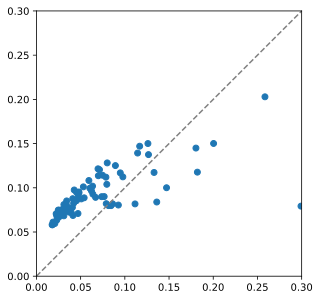

In [41]:
def exact_elk(mu1: Tensor, sigma1: Tensor, mu2: Tensor, sigma2: Tensor) -> Tensor:
    """Implements the exact, analytical ELK of two Gaussians as seen in 3.2.1

    Args:
        mu1, sigma1, mu2, sigma2: Float tensors of shape (n,) where the ELK is calculated
            for normals with  the corresponding means and standard deviations, resulting in
            n ELKs.

    Returns:
        A float tensor of shape (n,), containing the exact ELKs for normals with the
        corresponding means and standard deviations.
    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    sigma1_sq = sigma1 * sigma1
    sigma2_sq = sigma2 * sigma2
    
    numerator = (mu1 / sigma1_sq) + (mu2 / sigma2_sq)
    denominator = (1.0 / sigma1_sq) + (1.0 / sigma2_sq)
    mu_tilda = numerator / denominator
    
    sigma_tilda_sq = 1.0 / denominator
    exponent = -0.5 * (
        (mu1 * mu1) / sigma1_sq + 
        (mu2 * mu2) / sigma2_sq - 
        (mu_tilda * mu_tilda) / sigma_tilda_sq
    )
    
    coefficient = 1.0 / (torch.sqrt(torch.tensor(2.0 * torch.pi)) * sigma1 * sigma2)
    elk = coefficient * torch.exp(exponent)
    
    return elk

print(exact_elk(torch.zeros(1), torch.ones(1), torch.ones(1), torch.ones(1) * 2))

def plot_comparison(n: int = 100) -> None:
    """Calculates the exact and approximate ELK for n pairs of normal distributions with
    different parameters. Then plots the exact vs. approximate results in a scatterplot.

    Args:
        n: Number of pairs of distributions.

    """
    # Generate some random parameters for our distributions
    mu1s = torch.zeros(n).uniform_()
    mu2s = torch.zeros(n).uniform_()
    sigma1s = torch.zeros(n).uniform_() * 5
    sigma2s = torch.zeros(n).uniform_() * 5

    #### >>>> PUT YOUR SOLUTION HERE <<<<
    # Calculate exact and approx ELK for each entry in (mu1s, sigma1s) vs (mu2s, sigma2s)
    exact = exact_elk(mu1s, sigma1s, mu2s, sigma2s)
    approx = torch.zeros(n)
    for i in range(n):
        approx[i] = mc_elk(mu1s[i:i+1], sigma1s[i:i+1], mu2s[i:i+1], sigma2s[i:i+1], n_mc_samples=100)
    print (exact.size(),approx.size())
    #### >>>> END OF YOUR SOLUTION <<<<

    # Plot
    plt.plot([0, 1], [0, 1], color="grey", linestyle="dashed")
    plt.scatter(exact, approx)
    # You will probably run into numerical issues when using the non-logarithmed ELK for
    # high values
    plt.xlim(0, 0.3)
    plt.ylim(0, 0.3)
    plt.gca().set_aspect("equal")


plot_comparison()

## 3.3 Large Language Models and Uncertainty (12 points)

In this exercise, we will use the already familiar HuggingFace interface to inject uncertainty into LLMs and evaluate their calibration.

### 3.3.1 Text Generation (8 points)

Let's first load `GPT-2`, a fairly small autoregressive model we will work with for the first part of the exercise.

In [42]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The simplest and cheapest way of integrating uncertainty estimation in an LLM and approximating the model posterior is using MC dropout to obtain several models. We use this solely for simplicity: there are much more sophisticated model posteriors (such as [HET-XL](https://arxiv.org/abs/2301.12860) or [SNGP](https://arxiv.org/abs/2006.10108)) out there.

Complete the implementation of the function `predict_with_uncertainty` that returns the epistemic, aleatoric, and predictive uncertainty per each token. Mathematically, for a token $x$ and models $f_1, \dots, f_M$ sampled from the dropout posterior,
$$
\begin{align*}
\text{EU}(x) &= \text{JSD}_{f_1, \dots, f_M}(x) = \mathbb{H}\left(\frac{1}{M}\sum_{i=1}^M f_i(x)\right) - \frac{1}{M}\sum_{i=1}^M \mathbb{H}\left(f_i(x)\right)\\
\text{AU}(x) &= \frac{1}{M}\sum_{i=1}^M \mathbb{H}\left(f_i(x)\right)\\
\text{PU}(x) &= \mathbb{H}\left(\frac{1}{M}\sum_{i=1}^M f_i(x)\right).
\end{align*}
$$
With this setup, it trivially holds that $\text{PU}(x) = \text{EU}(x) + \text{AU}(x)$. Take a moment to understand why (1) $\text{EU}(x)$ measures parameter uncertainty (as model disagreement), (2) $\text{AU}(x)$ approximates the stochasticity of the generative process, and $\text{PU}(x)$ contains both previous sources of uncertainty. If you feel convinced and find the metrics plausible, let's proceed.

*Hint: It is often useful to think about extreme scenarios: What is the highest possible $\text{EU}(x)$? How do the models behave in that case? What happens to $\text{PU}(x)$ when the aleatoric uncertainty is high but the epistemic uncertainty is low? What happens in the opposite case?*

*Question to the curious reader: Is $\text{PU}(x)$ connected to the notion of correctness that was introduced in the lecture? Your findings might point you to two separate interpretations of the predictive uncertainty.*

In [ ]:
# Function to get model predictions with uncertainties
@torch.no_grad()
def predict_with_uncertainty(model, text, n_samples=50):
    model.eval()
    enable_dropout(model)
    logits_list = []

    # Get multiple predictions using dropout
    for _ in range(n_samples):
        inputs = tokenizer(text, return_tensors="pt").to(device)
        logits = model(**inputs).logits
        logits_list.append(logits)

    #### >>>> PUT YOUR SOLUTION HERE <<<<
    # Implement the above formula for PU(x) and AU(x).
    # You get EU(x) trivially from these.
    # Don't aggregate the uncertainties over the tokens.
    # You should construct normalized probabilities.
    
    #### >>>> END OF YOUR SOLUTION <<<<

    return eu_per_token, au_per_token, pu_per_token

Now we have a tool to obtain token-wise uncertainties. Below, we provide a function to visualize the epistemic and aleatoric uncertainties. (Predictive uncertainty is left out, as it is just the sum of the previous two following the above definition.)

In [ ]:
def visualize_uncertainty(sentence, epistemic, aleatoric):
    # Tokenize the sentence to obtain individual words
    epistemic = epistemic.cpu()
    aleatoric = aleatoric.cpu()
    tokens = tokenizer.tokenize(sentence)

    # Create a bar plot
    x = np.arange(len(tokens))
    width = 0.35

    fig, ax = plt.subplots()

    rects1 = ax.bar(
        x - width / 2, epistemic, width, label="Epistemic Uncertainty", alpha=0.8
    )
    rects2 = ax.bar(
        x + width / 2, aleatoric, width, label="Aleatoric Uncertainty", alpha=0.8
    )

    ax.set_xlabel("Tokens")
    ax.set_ylabel("Uncertainty")
    ax.set_title("Uncertainties per token in the input sentence")
    ax.set_xticks(x)
    ax.set_xticklabels(tokens, rotation=45, ha="right")
    ax.legend()

    # Function to auto label the bars with their height values
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height:.2f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 1),
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

Now it's your turn. Experiment with the aleatoric and epistemic uncertainties and write a report in which you address the following points. You can be brief.
- How do these behave on "strange" sentences? Based on your intuition of what kind of texts GPT-2 was trained on, what sentences would you consider out-of-distribution?
- Do you see a tendency of how the token index affects the associated uncertainties?
- Are the magnitudes of the two uncertainty sources comparable?
- How stable are the uncertainty values across different runs of the same cell?
- Think of a simple, factually correct sentence. Try to modify a single word to make a completely nonsensical sentence. Do you see a change in the uncertainties between the two sentences? Are these changes stable w.r.t. stochasticity?

In [ ]:
# Test on ambiguous sentences, incorrect sentences, etc.
#### >>>> PUT YOUR SOLUTION HERE <<<<
sentence = ...
#### >>>> END OF YOUR SOLUTION <<<<
epistemic_uncertainty, aleatoric_uncertainty, _ = predict_with_uncertainty(model, sentence)

visualize_uncertainty(sentence, epistemic_uncertainty, aleatoric_uncertainty)
print(f"Average Epistemic Uncertainty: {epistemic_uncertainty.mean().item():.4f}")
print(f"Average Aleatoric Uncertainty: {aleatoric_uncertainty.mean().item():.4f}")

Let's spend a bit more time on trying to detect factual errors in the input using uncertainty. First, complete the code below using the function `roc_auroc_score`. Check where it's imported from and try to understand its inputs. Then, run the cell and observe the results. Which type of uncertainty is the most predictive of correctness? Now, run the cell multiple times. Are the results stable over stochasticity? Would you trust a system that tries to detect falsehood using some of these uncertainties?

*Note: While the results might be interesting on their own, consider the fact that the MC dropout is a simple approximate posterior and the chosen model is also far from being state-of-the-art.*

In [ ]:
sentences = [
    "Donald Trump is a British songwriter.",
    "Donald Trump is an American politician and businessman.",
    "Albert Einstein is an Indian physicist.",
    "Edward Teller is a Hungarian physicist.",
    "The first World War was in the 14th century.",
    "The Declaration of Independence was signed in 1776.",
    "John von Neumann has been to Los Alamos.",
    "The Sun has an extremely cold temperature.",
    "Germany is a country in America.",
    "Michael Jackson was an extremely popular black singer.",
    # Feel free to extend/change this list if you get more interesting results that way.
]
correctness = np.array([0, 1, 0, 1, 0, 1, 1, 0, 0, 1])

eus = []
aus = []
pus = []
for sentence in sentences:
    (
        epistemic_uncertainty,
        aleatoric_uncertainty,
        predictive_uncertainty,
    ) = predict_with_uncertainty(model, sentence)
    eu = epistemic_uncertainty.mean().item()
    au = aleatoric_uncertainty.mean().item()
    pu = predictive_uncertainty.mean().item()
    eus.append(eu)
    aus.append(au)
    pus.append(pu)

eus = np.array(eus)
aus = np.array(aus)
pus = np.array(pus)
#### >>>> PUT YOUR SOLUTION HERE <<<<
# Print the AUROC scores of the negative epistemic, aleatoric, and predictive uncertainties
# against the correctness of prediction.
#### >>>> END OF YOUR SOLUTION <<<<

### 3.3.2 Named Entity Recognition (4 points)

Let's turn to Named Entity Recognition. Don't worry, this part doesn't need new ideas. We'll use our uncertainty estimators from above in a different setting: Named Entity Recognition, where we aim to detect different types of named entities in the input (such as people, geographical locations, institutions, or brands).

In [ ]:
# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
model = model.to(device)

What uncertainties do we obtain for the individual tokens in a toy example?

In [ ]:
text = "HuggingFace is a company based in New York."
tokens = tokenizer.tokenize(text)

eu, au, _ = predict_with_uncertainty(model, text)

for token, epistemic, aleatoric in zip(tokens, eu, au):
    print(f"{token}\t\tEpistemic: {epistemic:.4f}\tAleatoric: {aleatoric:.4f}")

Now, we can check how well the model's correctness correlates with our uncertainty estimates on the `conll2003` dataset. First, we need some boilerplate code to align the dataset labels with the tokens. This is needed because the tokenizer for our model is a subword tokenizer whereas the dataset labels correspond to words. This means that our model predicts a named entity class for each subword token, but the labels for the sentences are for individual words.

You don't need to understand the boilerplate code, but feel free to explore it if you feel confused by the subsequent code cell.

In [ ]:
# Load the dataset
raw_datasets = load_dataset("conll2003")


# Function to align labels with tokens
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels


# Function to tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs


# Tokenize and align the dataset
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Below, we evaluate our uncertainty estimators on how well they can predict the correctness of our model's per-token classification. Which uncertainty metric results in the highest AUROC? How stable are these AUROC results with the stochasticity in the model posterior? Would you trust these estimates compared to the GPT-2 ones?

In [ ]:
def evaluate_aurocs(tokenized_datasets, model, tokenizer):
    # Initial lists to store results
    correctness = []
    eus = []
    aus = []
    pus = []

    # Evaluate on 16 test examples
    # These are 16 test samples that might actually appear in natural language
    for idx in tqdm(range(300, 317)):
        sample = tokenized_datasets["test"][idx]

        # Get the text sentence from token IDs
        sentence = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)

        # Get uncertainties
        #### >>>> PUT YOUR SOLUTION HERE <<<<
        eu, au, pu = ...
        #### >>>> END OF YOUR SOLUTION <<<<

        # Get model's predictions
        inputs = tokenizer(sentence, return_tensors="pt").to(device)
        logits = model(**inputs).logits
        predictions = torch.argmax(logits, dim=-1)[0].tolist()

        # Check correctness and store results into
        # `correctness`, `eus`, `aus`, and `pus`
        for true_label, pred, eu_val, au_val, pu_val in zip(
            sample["labels"], predictions, eu, au, pu
        ):
            if true_label != -100:  # Exclude special tokens
                #### >>>> PUT YOUR SOLUTION HERE <<<<

                #### >>>> END OF YOUR SOLUTION <<<<

    # Compute AUROC
    epistemic_auroc = roc_auc_score(correctness, -np.array(eus))
    aleatoric_auroc = roc_auc_score(correctness, -np.array(aus))
    predictive_auroc = roc_auc_score(correctness, -np.array(pus))

    print("\nAccuracy:", sum(map(int, correctness)) / len(correctness))
    print("Epistemic AUROC:", epistemic_auroc)
    print("Aleatoric AUROC:", aleatoric_auroc)
    print("Predictive AUROC:", predictive_auroc)

    return correctness, eus, aus, pus

correctness, eus, aus, pus = evaluate_aurocs(tokenized_datasets, model, tokenizer)

Let's verify our results visually as well. Make a plot containing the epistemic uncertainties separately for correct and incorrect tokens, and see whether you find linear separability. Choose your plot type and limits carefully to convey your message. Interpret your results.

In [ ]:
plt.figure(figsize=(10, 6))
#### >>>> PUT YOUR SOLUTION HERE <<<<

#### >>>> END OF YOUR SOLUTION <<<<
plt.show()

# **4. Relationships Between Predictive, Aleatoric, and Epistemic Uncertainty (17 points)**
**Recommended start: 23.01.2025**

In the last exercise, we will relate different sources of uncertainty by exact formulas. We will gain an understanding for the relationship of predictive, aleatoric, and epistemic uncertainty through various uncertainty decompositions. Note that "the" uncertainty decomposition doesn't exist. There are many sensible formulations; what performs best for your specific use case should be given preference.

## 4.1 A Risk-based Predictive Uncertainty Decomposition (6 points)

#### 4.1.1 Regression (3 points)

Consider a regression problem with label space $\mathcal{Y} = \mathbb{R}$ and pointwise generative process $P(Y \mid X = x) = \mathcal{N}\left(Y; \mu(x), \sigma^2(x)\right)$. We choose the squared loss $\ell(y, a) = (y - a)^2$ where $a \in \mathcal{A} = \mathbb{R}$ is an element of the action space.

(a) Show that the pointwise risk, defined as $R(f, x) = \mathbb{E}_{P(Y \mid X = x)}\left[\ell(Y, f(x))\right]$ is equal to $\sigma^2(x) + (f(x) - \mu(x))^2$. Does this value capture our desiderata from predictive uncertainty? Argue based on intuitive definitions from the lecture.

**WRITE YOUR ANSWER HERE**

(b) Argue whether $R(f^*, x)$ is a reasonable aleatoric uncertainty metric based on the informal definition from the lecture.

**WRITE YOUR ANSWER HERE**

#### 4.1.2 Classification (3 points)

Consider a classification problem with label space $\mathcal{Y} = \{1, \dots, K\}$ and pointwise generative process $P(Y \mid X = x) = \operatorname{Cat}(\mu(x))$. We choose the negative log-likelihood (NLL) loss $\ell(y, a) = -\log a_y$ where $a \in \mathcal{A} = \Delta^K$ is an element of the action space, i.e., the $K-1$-dimensional probability simplex.

(a) Show that the pointwise risk is equal to $\mathbb{H}\left(\mu(x), f(x)\right)$. Does this value capture our desiderata from predictive uncertainty?

**WRITE YOUR ANSWER HERE**

(b) Argue whether $R(f^*, x)$ is a reasonable aleatoric uncertainty metric.

**WRITE YOUR ANSWER HERE**

## 4.2 An Information-Theoretical Predictive Uncertainty Decomposition (5 points)

Let the distribution $P(Y \mid x, \omega)$ denote model $\omega$s prediction for input $x$ (e.g., by considering the model's softmax output). Further, let $P(Y \mid x, \mathcal{D}) := \int_\Omega P(Y \mid x, \omega) dP(\omega \mid \mathcal{D})$ be the so-called predictive distribution. Let $\mathbb{I}(Y; \omega \mid x, \mathcal{D}) := D_\text{KL}\left(P(Y, \omega \mid x, \mathcal{D})\ \Vert\ P(Y \mid x)P(\omega \mid \mathcal{D})\right)$ be the mutual information of the variables $Y \mid x$ and $\omega \mid \mathcal{D}$. *Note: the decomposition we discussed for the NLP models has close ties with this one.*

(a) Try to gain an intuition for the mutual information. What is its minimizer and for what $P(Y, \omega \mid x, \mathcal{D})$ does it happen?

**WRITE YOUR ANSWER HERE**

(b) Show that $$\mathbb{H}_{P(Y \mid x, \mathcal{D})}(Y) = \mathbb{I}(Y; \omega \mid x, \mathcal{D}) + \mathbb{E}_{P(\omega \mid \mathcal{D})}\left[\mathbb{H}_{P(Y \mid x, \omega)}(Y)\right].$$

**WRITE YOUR ANSWER HERE**

(c) Based on your findings and the intuition from (a), what different sources of uncertainty do the individual components measure? Like in the previous sections, it suffices to argue based on informal desiderata from the lecture.

**WRITE YOUR ANSWER HERE**

## 4.3 Evidential methods as a straightforward Bayesian decomposition (6 points)

Evidential Deep Learning allows the inference of epistemic uncertainty in a single forward pass (i.e., without Monte-Carlo samples) by fitting a prior distribution over likelihood functions. Conjugacy allows us to formulate a tractable posterior predictive given a likelihood and conjugate prior distribution. We use the negative log-likelihood of this posterior predictive as an objective function for training.

### 4.3.1 Fundamentals of Evidential Deep Learning (3 points)

In the following, we will employ EDL in a regression setting. For simplicity, we assume a Gaussian likelihood and a Normal-Inverse-Gamma (NIG) prior. The NLL loss-function is composed as follows.

$$
\begin{split}
\mathcal{L}_{nll} &= - \log \int_{\sigma^2=0}^{\infty} \int_{\mu=-\infty}^{\infty} \mathcal{N}(y \vert \mu, \sigma^2) \mathrm{NIG}(\mu, \sigma^2 \vert \mu_0, \alpha, \beta, \nu) d\mu d\sigma^2 \\
&= - \log \mathrm{St}_{2\alpha}\left(y; \mu_0, \frac{\beta (1 + \nu)}{\nu \alpha} \right)
\end{split}
$$

Post-training, the relevant quantities can be computed from the predicted parameters.

$$
\hat y = \mu_0, \quad \underbrace{\mathbb{E}[\sigma^2] = \frac{\beta}{\alpha - 1}}_{aleatoric}, \quad \underbrace{\mathrm{Var}[\mu] = \frac{\beta}{\nu(\alpha-1)}}_{epistemic}
$$

(a) Discuss the role of the evidential parameters $\{\mu_0, \nu, \alpha, \beta\}$ in the EDL regression model with regards to their impact on uncertainty estimates. Provide examples of how these parameters might change under varied data scenarios, such as high noise or OOD samples.

**WRITE YOUR ANSWER HERE**

(b) Explain how EDL differs from alternative uncertainty estimation methods, such as Monte Carlo dropout, deep ensembles, or other Bayesian approximations. Focus on computational complexity and the ability to distinguish between aleatoric and epistemic uncertainty.

**WRITE YOUR ANSWER HERE**

### 4.3.2 Limitations of EDL (3 points)

While the formulation of EDL is analytically sound, the approach is plagued by a lack of proper scoring rules. A common, partial, remedy is the addition of heuristic regularization. In the following exercise, you will investigate the impact of regularization on a simple EDL toy experiment, there will be no coding required.

First, we will define both loss functions.

In [ ]:
# Define NLL loss functions
def NIG_NLL(y, mu, nu, alpha, beta):
    two_b_lambda = 2 * beta * (1 + nu)
    nll = 0.5 * torch.log(torch.pi / (nu + 1e-8)) \
        - alpha * torch.log(two_b_lambda) \
        + (alpha + 0.5) * torch.log(nu * torch.square(y - mu) + two_b_lambda) \
        + torch.lgamma(alpha) \
        - torch.lgamma(alpha + 0.5)

    return nll.mean()


def reg_NIG_NLL(y, mu, nu, alpha, beta):
    two_b_lambda = 2 * beta * (1 + nu)
    nll = 0.5 * torch.log(torch.pi / (nu + 1e-8)) \
        - alpha * torch.log(two_b_lambda) \
        + (alpha + 0.5) * torch.log(nu * torch.square(y - mu) + two_b_lambda) \
        + torch.lgamma(alpha) \
        - torch.lgamma(alpha + 0.5)

    reg = torch.square(y - mu).detach() * torch.reciprocal(beta / (alpha - 1.)) + 2 * alpha
    loss = nll + 1e-2 * reg
    return loss.mean()

Next, some simple code to run and visualize the experiments.

In [ ]:
from unc_utils import edl_train, edl_visualize, UnivariateNonUniformData, DenseInverseGamma, UnivariateDerNet

EPOCHS=120
OOD_lower = -10.
OOD_upper = 20.

net = UnivariateDerNet()
net.to(device)

# Generate simple toy problem
train_data = UnivariateNonUniformData(N=2000, X_intervals=[(-2., 10.)], X_distribution="gaussian")
test_data = UnivariateNonUniformData(N=100, X_intervals=[(OOD_lower, OOD_upper)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

# Define optimizer
optimizer_params = {
    "lr": 1e-03,
    "betas": (0.9, 0.999),
    "eps": 1e-8,
    "weight_decay": 1e-2,
    "amsgrad": False}

optimizer = torch.optim.AdamW(net.parameters(), **optimizer_params)

# Initialize figures
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=optimizer_params["lr"], steps_per_epoch=len(train_loader), epochs=EPOCHS)

# Run training
losses = edl_train(net=net,
    criterion=NIG_NLL,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    test_data=test_data,
    epochs=EPOCHS,
    device=device)

# Evaluate on larger subspace including unseen data
line_x = np.linspace(OOD_lower, OOD_upper, num=200)
outputs = net(torch.Tensor(np.expand_dims(line_x, axis=1)).to(device))
mu0, nu, alpha, beta = (out.detach().cpu().numpy() for out in outputs)

# Compute uncertainties according to Normal-Inverse-Gamma definition
aleatoric = np.sqrt(beta / (alpha - 1.))
epistemic = np.sqrt(beta / (nu * (alpha - 1.)))

edl_visualize(mu0, aleatoric, epistemic, train_data, test_data, axes[0])

# Reset scheduler and network parameters
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=optimizer_params["lr"], steps_per_epoch=len(train_loader), epochs=EPOCHS)
net.reset()

# Run training
losses = edl_train(net=net,
    criterion=reg_NIG_NLL,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    test_data=test_data,
    epochs=EPOCHS,
    device=device)

# Evaluate on larger subspace including unseen data
line_x = np.linspace(OOD_lower, OOD_upper, num=200)
outputs = net(torch.Tensor(np.expand_dims(line_x, axis=1)).to(device))
mu0, nu, alpha, beta = (out.detach().cpu().numpy() for out in outputs)

# Compute uncertainties according to Normal-Inverse-Gamma definition
aleatoric = np.sqrt(beta / (alpha - 1.))
epistemic = np.sqrt(beta / (nu * (alpha - 1.)))

edl_visualize(mu0, aleatoric, epistemic, train_data, test_data, axes[1])
plt.show()

Now that you've executed the code,

(a) study the figures and report your observations. What does the regularizer improve exactly?

**WRITE YOUR ANSWER HERE**

(b) The provided regularizer $\lfloor (y - \mu_0)^2 \rfloor \left( \frac{\beta}{\alpha - 1} \right)^{-1} + 2\alpha$ mirrors another well known negative log-likelihood function closely. State which one and how this might help obtain accurate uncertainty forecasts.

**WRITE YOUR ANSWER HERE**

(c) Propose a novel regularizer based on the interpretations of the estimated parameters $\{\mu_0, \nu, \alpha, \beta\}$ seen in the lecture. You may further use $y, \hat y$ in your formulation. Argue why your proposed regularizer should be a reasonable choice. You can test your proposition using the code above. (Sound argumentation will net full points, even if your regularizer does not improve performance empirically.)

**WRITE YOUR ANSWER HERE**

You did it! This was the last exercise of the course. I hope you had a great time! Best of luck on the exam!